In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import MRS.api as mrs
import MRS.analysis as ana
import MRS.utils as ut
import MRS.data as mrd
import os.path as op
%matplotlib inline

/Users/arokem/source/MRS/MRS/api.py:19: UserWarning: Nipype is not installed. Some functions might not work
  warnings.warn("Nipype is not installed. Some functions might not work")


In [2]:
import nitime as nt
import nitime.analysis as nta
import nitime.viz as viz
import scipy.stats as stats
import scipy.io as sio
import os

/Users/arokem/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# 1H Magnetic Resonance Spectroscopy (1H-MRS) 

## Measuring GABA concentrations *in vivo* in human 


# Principles of MRS measurement

Following a $90^\circ$ square (broadband) pulse:  

$FID(R) = M_x(t) = M_0 sin[(\omega_0 - \omega)t + \phi] e^{-(t/T^*_2)} $


$FID(I) = M_y(t) = M_0 cos[(\omega_0 - \omega)t + \phi] e^{-(t/T^*_2)}$ 

Where $\omega_0$ is the resonance frequency of the nucleus and $\omega$ is the center frequency of the RF pulse

In [3]:
def FID(t, M0=1, omega_0=128, omega=150, phi=0, T2_star=1.0):
    Mx = M0 * np.sin((omega_0 - omega) * t + phi) * np.exp(-(t / T2_star))
    My = M0 * np.cos((omega_0 - omega) * t + phi) * np.exp(-(t / T2_star))
    return Mx, My

In [4]:
def plot_fid(t, FID, omega=None, omega_0=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x,y = FID
    ax.plot(t, x, y)
    ax.plot(t ,x ,ax.get_zlim()[0], 'g')
    ax.plot(t ,np.zeros(y.shape) + ax.get_ylim()[1], x, 'r')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$M_x$')
    ax.set_zlabel(r'$M_y$')
    if omega is not None and omega_0 is not None:
        ax.set_title(r'$\omega_0=%s$  $\omega=%s$'%(omega_0, omega))
    fig.set_size_inches([8, 6])

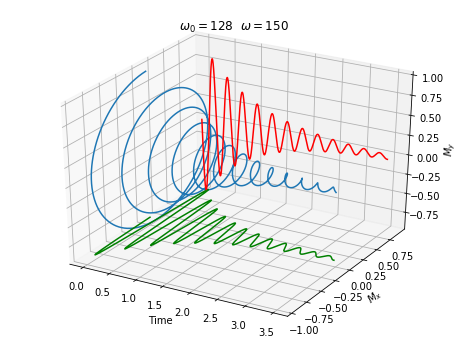

In [5]:
t = np.linspace(0,3.5,4096)
plot_fid(t, FID(t, omega=150, omega_0=128), 150, 128)

Fourier transforming the FID yields a complex spectrum: 

  $R(\omega) = A(\omega) cos \phi - D(\omega) sin \phi$

  $I(\omega) = A(\omega) sin \phi + D(\omega) cos \phi$

where: 

  $A(\omega) = \frac{M_0 T_2^*}{1 + (\omega_0-\omega)^2 T_2^{*2}}$

  $D(\omega) = \frac{M_0 T_2^{*2} (\omega_0-\omega)}{1 + (\omega_0-\omega)^2 T_2^*}$




In [6]:
def fid_disp(M0=1, omega0=128, omega=np.linspace(0,1024,4096), T2_star=1.0, phi=0):
    A = (M0*T2_star)/(1+((omega0-omega)**2)*T2_star**2)
    D = (M0*T2_star**2*(omega0-omega))/(1+((omega0-omega)**2)*T2_star**2)
    return A,D

def fid_fft(M0=1, omega0=128, omega=np.linspace(0,1024,4096), T2_star=1.0, phi=0):
    A,D = fid_disp(M0, omega0, omega, T2_star, phi)
    R = A * np.cos(phi) - D * np.sin(phi)
    I = A * np.sin(phi) + D * np.cos(phi)
    return R + I*1j

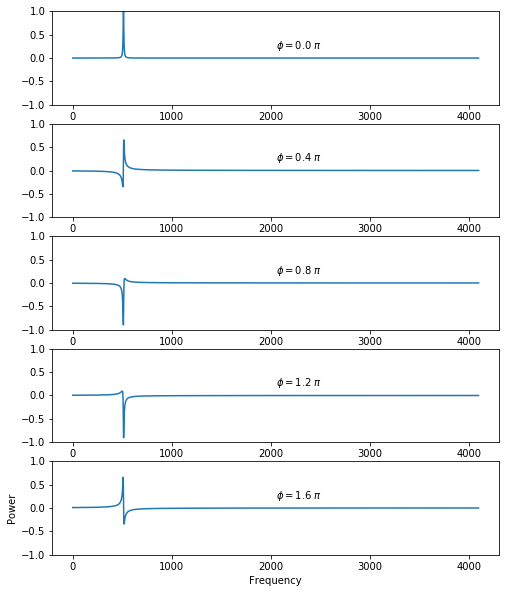

In [7]:
phis = np.linspace(0, 2*np.pi, 6)[:-1]
fig, ax = plt.subplots(len(phis))
for ii in range(len(phis)):
    ax[ii].plot(np.real(fid_fft(phi=phis[ii])))
    ax[ii].set_ylim([-1,1])
    ax[ii].text(0.5, 0.6, '$\phi=$%s $\pi$'%(phis[ii]/np.pi), transform=ax[ii].transAxes)
fig.set_size_inches([8,10])
ax[-1].set_xlabel('Frequency')
ax[-1].set_ylabel('Power')


In small organic molecules (such as GABA), hydrogen atoms are free to receive and release energy in MR experiments

Due to local shielding effects, their resonance frequency is shifted by some small amount

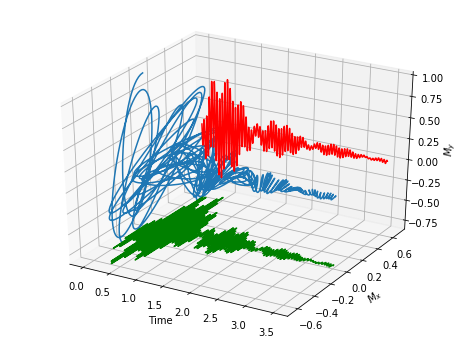

In [8]:
FID1=np.vstack(FID(t, M0=0.3, omega_0=128, omega=0, phi=0, T2_star=1.0))
FID2=np.vstack(FID(t, M0=0.2, omega_0=128, omega=150, phi=0, T2_star=1.0))
FID3=np.vstack(FID(t, M0=0.5, omega_0=128, omega=250, phi=0, T2_star=1.0))
my_fid = FID1 + FID2 + FID3
my_fid = my_fid[0] + my_fid[1] * 1j
plot_fid(t, (my_fid.real, my_fid.imag))

/Users/arokem/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


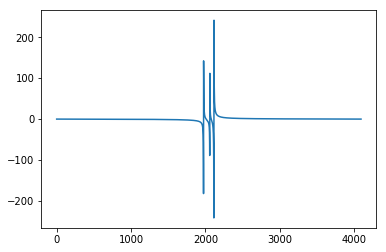

In [9]:
ft = np.fft.fftshift(np.fft.fft(my_fid))
plt.plot(ft)

/Users/arokem/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


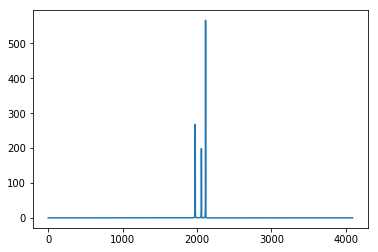

In [10]:
ft = np.fft.fftshift(np.fft.fft(my_fid * np.exp(-1j * 1.6)))
plt.plot(ft)

/Users/arokem/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


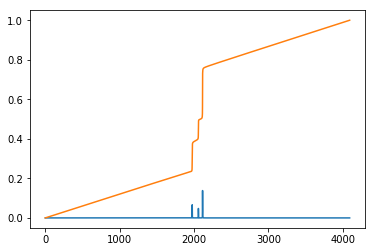

In [11]:
ft = ft/np.sum(ft)
plt.plot(ft)
plt.plot(np.cumsum(ft))

Because the shift (in Hz) depends on the magnetic field strength it is quantified in parts-per-million ('ppm')

The standard scale is relative to dimethyl sulfide (DMS), because its chemical shift is relatively stable in different temperatures. At body temperature, water is at 4.7 ppm 

In [12]:
mrd.fetch_from_sdr(data='example')

Done.
Files copied in folder /Users/arokem/MRS_data


In [13]:
fname = '12_1_PROBE_MEGA_L_Occ.nii.gz'
data_file = op.join(mrd.data_folder, fname)

In [14]:
G = mrs.GABA(data_file)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
water_hz = 0.0 # The center frequency of our RF pulse
water_ppm = 4.7 # Per convention
hz_per_ppm = 127.68 # at our 3T
sampling_rate = 5000. # Hz
n_samples = 4096
freq_hz = np.linspace(-sampling_rate/2., sampling_rate/2., n_samples)

freq_ppm = water_ppm - (freq_hz - water_hz)/hz_per_ppm

In [ ]:
def plot_fid_fft():
    fig, ax = plt.subplots(2)
    fig = viz.plot_tseries(
    nt.TimeSeries(data = [np.abs(G.water_fid[0,0])],#, np.imag(G.water_fid[0,0])],
    sampling_rate=5000.), ylabel='FID', fig = fig)
    ax[0].set_xlabel('Time(s)')
    #ax[1].plot(freq_ppm, np.fft.fftshift(np.fft.fft(G.water_fid[0,0])))
    idx = np.where(np.logical_and(freq_ppm>3, freq_ppm<5))
    ax[1].plot(freq_ppm[idx], np.fft.fftshift(np.fft.fft(G.water_fid[0,0]))[idx])
    ax[1].set_xlabel('Frequency (ppm)')
    ax[1].set_ylabel('Power')
    fig.set_size_inches([10,6])


In [ ]:
plot_fid(np.linspace(1, 3.5, n_samples), (np.real(G.water_fid[0,0]), np.imag(G.water_fid[0,0])))

In [ ]:
plot_fid_fft()

# Water suppression

- Water is present at very high concentrations drowning out signals from other molecules

- After excitation with a broad-band pulse, a broadband 180 to induce spin echo

- An additional frequency-selective 180 is applied to invert the evolution of water-bound protons

# Water suppression on

In [ ]:
def plot_fid_ft_w_suppressed():
    fig, ax = plt.subplots(3)
    fig = viz.plot_tseries(
    nt.TimeSeries(data = [np.abs(G.w_supp_fid[0,0])], #np.imag(G.w_supp_fid[0,0])],
                  sampling_rate=5000.), ylabel='FID', fig = fig)
    idx = np.where(np.logical_and(freq_ppm>0, freq_ppm<5))

    ax[1].plot(freq_ppm[idx], np.fft.fftshift(np.fft.fft(G.w_supp_fid[0,0]))[idx])
    ax[1].set_xlabel('Frequency (ppm)')

    idx = np.where(np.logical_and(freq_ppm>0, freq_ppm<4))
    ax[2].plot(freq_ppm[idx], np.fft.fftshift(np.fft.fft(G.w_supp_fid[0,0]))[idx])
    ax[2].set_xlabel('Frequency (ppm)')

    fig.set_size_inches([10,6])

In [ ]:
plot_fid(np.linspace(1,3.5, n_samples), (np.real(G.w_supp_fid[0,0]), np.imag(G.w_supp_fid[0,0])))

In [ ]:
plot_fid_ft_w_suppressed()

# Water-included data is used: 

- Suppressing residual water signal

- High SNR: used for coil combination and zero-order phase alignment

## J coupling

- Different hydrogen atoms bound covalently are physically coupled ("J coupling")

- Resonance in one affects resonance in another

- GABA has 3 resonance groups: at 1.9 ppm, 2.3 ppm and 3.0 ppm

# Problem : There are other resonances at these frequencies

In [ ]:
def plot_resonances():
    fig, ax = plt.subplots(1)
    fig.set_size_inches([8,6])
    ax.plot(G.f_ppm[G.idx], np.mean(G.echo_off, 0)[G.idx])
    ax.invert_xaxis()
    ax.annotate('NAA', xy=(2, 0.65),  xycoords='data', xytext=(50, -10), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    ax.annotate('Creatine', xy=(3.1, 0.4),  xycoords='data', xytext=(-80, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    ax.annotate('Glx', xy=(2.3, 0.1),  xycoords='data', xytext=(-30, 60), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    ax.annotate('Choline', xy=(3.3, 0.25),  xycoords='data', xytext=(-60, 40), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    ax.annotate('Myoinositol', xy=(4.0, 0.2),  xycoords='data', xytext=(-40, 30), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    ax.annotate('Lipids', xy=(1.4, 0.05),  xycoords='data', xytext=(20, 30), textcoords='offset points', arrowprops=dict(arrowstyle="->"))

    ax.set_xlabel('ppm')
    ax.set_ylabel('Power')

In [ ]:
plot_resonances()

# Solution : spectral editing

A frequency selective 180 can be used to excite the resonance around 1.9 ppm

Because of J-coupling, this also edits out the resonance at 3 ppm

The experiment is repeated twice, with and without editing

In [ ]:
def plot_two_echos():
    fig, ax = plt.subplots(3)
    fig.set_size_inches([8,8])
    ax[0].plot(G.f_ppm[G.idx], np.mean(G.echo_off, 0)[G.idx])
    ax[1].plot(G.f_ppm[G.idx], np.mean(G.echo_on, 0)[G.idx])
    ax[2].plot(G.f_ppm[G.idx], np.mean(G.diff_spectra,0)[G.idx])
    ax[2].set_xlabel('ppm')
    ax[0].set_title('GABA included')
    ax[1].set_title('GABA edited')
    ax[2].set_title('Difference')
    ax[2].annotate('GABA', xy=(3.0, 0.03),  xycoords='data', xytext=(-5, -40), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    ax[2].annotate('Glx', xy=(3.8, 0.01),  xycoords='data', xytext=(-15, -40), textcoords='offset points', arrowprops=dict(arrowstyle="->"))
    for a in ax:
        a.invert_xaxis()

In [ ]:
plot_two_echos()

# How reliable is that GABA peak?

In [ ]:
G.fit_gaba()
G.fit_glx()

In [ ]:
def plot_gaba_spec():
    fig, ax = plt.subplots(1)
    ax.plot(G.f_ppm[G.gaba_idx], G.diff_spectra[:, G.gaba_idx].T, color='b', alpha=0.3)
    ax.plot(G.f_ppm[G.gaba_idx], np.mean(G.diff_spectra[:, G.gaba_idx], 0), color='r', linewidth=4, label='Average')
    ax.invert_xaxis()
    plt.legend(loc=2)
    ax.set_xlabel('ppm')

In [ ]:
plot_gaba_spec()

What can we do to improve the situation ?

## First order phase correction

Strategy : fit the creatine peak as a Lorentzian, including phase

Then, rotate the phase of the spectrum by that amount across GABA-including and GABA-edited spectra

## Outlier exclusion

Strategy : use the creating model parameters to detect the presence of outliers in the data

In [ ]:
def show_creatine_model():
    fig, ax = plt.subplots(2)
    ax[0].matshow(np.real(G.echo1[:, G.cr_idx]), cmap=matplotlib.cm.Reds)
    ax[0].set_xticks([0,53])
    ax[0].set_xticklabels([str(x) for x in [3.2, 2.7]])
    ax[0].set_xlabel('ppm')
    ax[1].matshow(G.creatine_model, cmap=matplotlib.cm.Reds)
    ax[1].set_xticks([])
    fig.set_size_inches([10,8])

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(G.f_ppm[G.idx], stats.nanmean(G.sum_spectra[G._cr_transients, :], 1).squeeze()[G.idx])
ax.plot(G.f_ppm[G.cr_idx], stats.nanmean(G.creatine_model, 0), 'r')
ax.invert_xaxis()
ax.set_xlabel('ppm')
fig.set_size_inches([10,6])

Then - fit a model for the GABA part of the spectrum on the rephased difference spectra:

In [ ]:
fig, ax = plt.subplots(2)
ax[0].matshow(np.real(G.diff_spectra[:, G.gaba_idx]), cmap=matplotlib.cm.Reds)
ax[0].set_xticks([0,63])
ax[0].set_xticklabels([str(x) for x in [3.4, 2.8]])
ax[0].set_xlabel('ppm')
ax[1].matshow(G.gaba_model, cmap=matplotlib.cm.Reds)
ax[1].set_xticks([])
fig.set_size_inches([10,8])

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(G.f_ppm[G.idx], stats.nanmean(G.diff_spectra[G._gaba_transients, G.idx], 1).squeeze())
ax.plot(G.f_ppm[G.gaba_idx], stats.nanmean(G.gaba_model, 0), 'r')
ax.plot(G.f_ppm[G.glx_idx], stats.nanmean(G.glx_model, 0), 'r')
ax.invert_xaxis()
ax.set_xlabel('ppm')
fig.set_size_inches([10,6])

# Quanfication

## Problem : the magnitude of these peaks is affected by all kinds of things

The proportion of gray matter in the voxel

Coil gain

Editing efficiency 

The editing pulse is broad: GABA at 1.9 ppm is co-edited with a lysine resonance at 1.7 ppm

This leads to contamination of the signal by lysine-containing macromolecules

# "Solution" : measure relative concentration

$\frac{[GABA]}{[Cr]} \propto \frac{AUC_{GABA}}{AUC_{Cr}}$

In [ ]:
stats.nanmean(G.gaba_auc)/stats.nanmean(G.creatine_auc)

Similarly for the glutamate/glutamine peak at 3.7 ppm:

In [ ]:
stats.nanmean(G.glx_auc)/stats.nanmean(G.creatine_auc)